[![Labellerr](https://cdn.labellerr.com/%200%20Labellerr%20template/labellerr_banner.jpg)](https://www.google.com)

# How to Perform Various Vision Tasks Using YOLO

---

[![labellerr](https://img.shields.io/badge/Labellerr-BLOG-black.svg)](https://www.labellerr.com/blog/<BLOG_NAME>)
[![Youtube](https://img.shields.io/badge/Labellerr-YouTube-b31b1b.svg)](https://www.youtube.com/@Labellerr)
[![Github](https://img.shields.io/badge/Labellerr-GitHub-green.svg)](https://github.com/Labellerr/Hands-On-Learning-in-Computer-Vision)
[![Scientific Paper](https://img.shields.io/badge/Official-Paper-blue.svg)](<PAPER LINK>)





# Vision Tasks Supported by YOLO

- Object Detection
- Image segmentation
- Classification
- Pose estimation
- Oriented Object Detection (OBB)

In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
from ultralytics import YOLO

In [2]:
!wget -O sample-2.jpg http://farm9.staticflickr.com/8119/8626487728_1e16dc0767_z.jpg

--2025-05-09 06:03:13--  http://farm9.staticflickr.com/8119/8626487728_1e16dc0767_z.jpg
Resolving farm9.staticflickr.com (farm9.staticflickr.com)... 108.156.94.80, 2600:9000:24ce:e200:0:5a51:64c9:c681, 2600:9000:24ce:c400:0:5a51:64c9:c681, ...
Connecting to farm9.staticflickr.com (farm9.staticflickr.com)|108.156.94.80|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://farm9.staticflickr.com/8119/8626487728_1e16dc0767_z.jpg [following]
--2025-05-09 06:03:13--  https://farm9.staticflickr.com/8119/8626487728_1e16dc0767_z.jpg
Connecting to farm9.staticflickr.com (farm9.staticflickr.com)|108.156.94.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘sample-2.jpg’

sample-2.jpg            [ <=>                ] 116.72K  --.-KB/s    in 0.02s   

2025-05-09 06:03:13 (5.09 MB/s) - ‘sample-2.jpg’ saved [119521]



In [3]:
sample = Image.open('sample-2.jpg').convert('RGB')
plt.figure(figsize=(10, 10))
plt.title('Sample Image for Segementation')
plt.axis('off')
plt.imshow(sample)

# Image Segmentation

In [4]:
# Load a model
model = YOLO("yolo11n-seg.pt")  # load an official model

# Predict with the model
segments = model("sample-2.jpg")
    

image 1/1 /home/HP/Jupyter_Notebooks/YOLO-EXP/sample-2.jpg: 384x640 2 persons, 2 horses, 85.7ms
Speed: 6.9ms preprocess, 85.7ms inference, 484.2ms postprocess per image at shape (1, 3, 384, 640)


In [5]:
segments[0].verbose()

'2 persons, 2 horses, '

In [6]:
plt.figure(figsize=(10, 10))  # set figure size
plt.title("YOLOv11 Segmentation Results")  # set title
plt.axis('off')  # hide axes
plt.imshow(cv2.cvtColor(segments[0].plot(), cv2.COLOR_BGR2RGB))  # plot results

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from ultralytics import YOLO
from ultralytics.utils.plotting import colors # Utility for class colors
import requests # For image loading example

# --- Optional: Ensure necessary libraries are installed ---
# pip install ultralytics opencv-python matplotlib numpy requests Pillow

def visualize_image_masks_only(results, mask_alpha=0.5):
    """
    Visualizes YOLOv11 segmentation results on a single image, drawing only
    colored masks with transparency, different colors per class.

    Args:
        results: The list of Results objects returned by model(image).
                 Assumes prediction was run on a single image (uses results[0]).
        mask_alpha (float): Transparency level for the masks (0.0 to 1.0).
                             Lower values are more transparent.
    """
    if not results:
        print("No results to visualize.")
        return

    try:
        result = results[0]
    except IndexError:
        print("Results list is empty.")
        return

    # Check if necessary data exists
    if result.masks is None or result.boxes is None:
        print("No masks or boxes found in the results. Cannot visualize masks.")
        # Optionally display original image
        try:
             orig_img_display = np.array(result.orig_img)
             # Check color order if needed - assume it might be BGR from cv2 load
             if orig_img_display.shape[2] == 3: # Check if it's color
                   try:
                       orig_img_rgb = cv2.cvtColor(orig_img_display, cv2.COLOR_BGR2RGB)
                   except Exception:
                        orig_img_rgb = orig_img_display # Assume RGB if conversion fails
             else:
                  orig_img_rgb = orig_img_display # Grayscale

             plt.figure(figsize=(10, 10))
             plt.imshow(orig_img_rgb)
             plt.title("Original Image (No Masks Found)")
             plt.axis('off')
             plt.show()
        except Exception as e:
             print(f"Could not display original image: {e}")
        return

    # Get original image
    annotated_image = result.orig_img.copy()
    img_height, img_width = annotated_image.shape[:2]

    # Get masks, boxes (for class IDs), and ensure they're numpy/cpu
    masks_data = result.masks.data.cpu().numpy()  # (N, H, W)
    # class_ids = result.boxes.cls.cpu().numpy().astype(int) # (N,) - More direct way
    # OR get from boxes.data if cls attribute isn't directly available everywhere:
    boxes_data = result.boxes.data.cpu().numpy()  # (N, 6) - xyxy, conf, cls
    class_ids = boxes_data[:, 5].astype(int)       # Extract class IDs

    if masks_data.shape[0] != len(class_ids):
        print("Warning: Mismatch between number of masks and boxes. Skipping visualization.")
        # Can potentially show original image here too
        return

    # Iterate through each detected object/mask
    for i in range(masks_data.shape[0]):
        mask = masks_data[i]        # Single mask (H, W) - often model input size
        class_id = class_ids[i]     # Corresponding class ID

        # Get the color for this class (BGR format from 'colors' utility)
        color_bgr = colors(class_id, bgr=True)

        # --- Resize Mask to Original Frame Size ---
        resized_mask = cv2.resize(mask, (img_width, img_height), interpolation=cv2.INTER_NEAREST)

        # --- Create a boolean mask ---
        boolean_mask = resized_mask > 0.5  # Threshold to get True/False values

        # --- Apply Colored Overlay using addWeighted for blending ---
        # Ensure the boolean mask is 3-channel for element-wise selection in color image
        # This is not strictly necessary if using boolean indexing correctly
        # boolean_mask_3channel = np.stack([boolean_mask]*3, axis=-1) # Alternative way

        # Get pixels from the original image where the mask is True
        original_pixels = annotated_image[boolean_mask]

        # Check if there are any pixels to color (mask might be empty after resize/threshold)
        if original_pixels.size > 0:
            # Create a solid color array matching the class color, for pixels in the mask
            # Important: The color needs to match the dtype of the image pixels (e.g., uint8)
            color_array_for_pixels = np.full(original_pixels.shape, color_bgr, dtype=annotated_image.dtype)

            # Blend original pixels with the class color
            blended_pixels = cv2.addWeighted(
                original_pixels,
                1 - mask_alpha,      # Weight for original pixels
                color_array_for_pixels,
                mask_alpha,          # Weight for the color overlay
                0                    # Gamma (typically 0)
            )

            # Put the blended pixels back into the annotated image
            annotated_image[boolean_mask] = blended_pixels

    # --- Display the result using Matplotlib ---
    # Convert the final image (which is likely BGR) to RGB for Matplotlib
    try:
        annotated_image_rgb = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
    except Exception:
         print("Warning: Could not convert final image to RGB. Displaying as is.")
         annotated_image_rgb = annotated_image # Display BGR if conversion fails


    plt.figure(figsize=(10, 10)) # Adjust size as needed
    plt.imshow(annotated_image_rgb)
    plt.title(f"Image with Segmentation Masks Only (alpha={mask_alpha})")
    plt.axis('off')
    plt.show()

In [8]:
visualize_image_masks_only(segments)

# Oriented Object Detection (OBB)

In [9]:
model_obb = YOLO("yolo11n-obb.pt")

# obb = model_obb.track("obb-4.mp4", show=False, save=True)

# Pose Estimation

In [10]:
model = YOLO("yolo11n-pose.pt")


image 1/1 /home/HP/Jupyter_Notebooks/YOLO-EXP/sample-3.jpg: 640x448 1 person, 85.6ms
Speed: 3.0ms preprocess, 85.6ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 448)


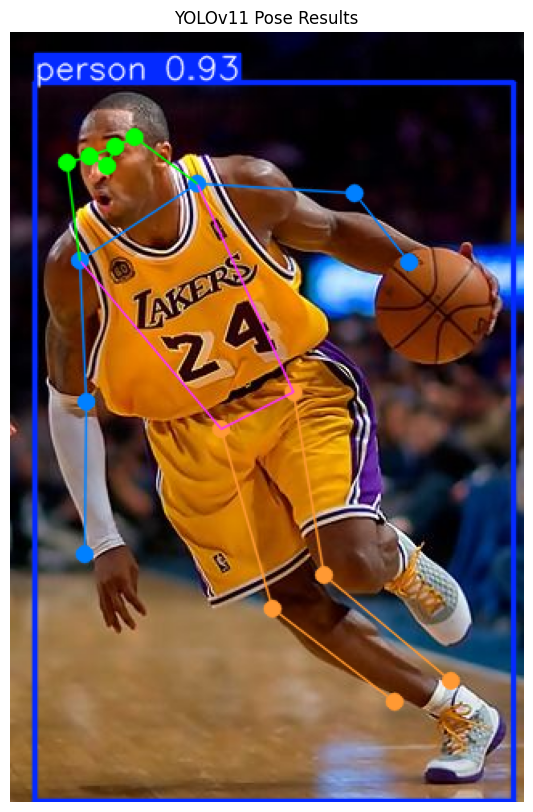

In [11]:
pose = model.predict("sample-3.jpg")
plt.figure(figsize=(10, 10))  # set figure size
plt.title("YOLOv11 Pose Results")  # set title
plt.axis('off')  # hide axes
plt.imshow(cv2.cvtColor(pose[0].plot(), cv2.COLOR_BGR2RGB))  # plot results

In [12]:
pose = model.predict("sample-4.jpg")
plt.figure(figsize=(10, 10))  # set figure size
plt.title("YOLOv11 Pose Results")  # set title
plt.axis('off')  # hide axes
plt.imshow(cv2.cvtColor(pose[0].plot(), cv2.COLOR_BGR2RGB))  # plot results


image 1/1 /home/HP/Jupyter_Notebooks/YOLO-EXP/sample-4.jpg: 640x384 1 person, 157.7ms
Speed: 3.2ms preprocess, 157.7ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 384)


# Classification

In [13]:
model = YOLO("yolo11n-cls.pt")


image 1/1 /home/HP/Jupyter_Notebooks/YOLO-EXP/sample-5.jpg: 224x224 vulture 0.90, bald_eagle 0.05, kite 0.03, hornbill 0.00, goose 0.00, 4.8ms
Speed: 19.7ms preprocess, 4.8ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)


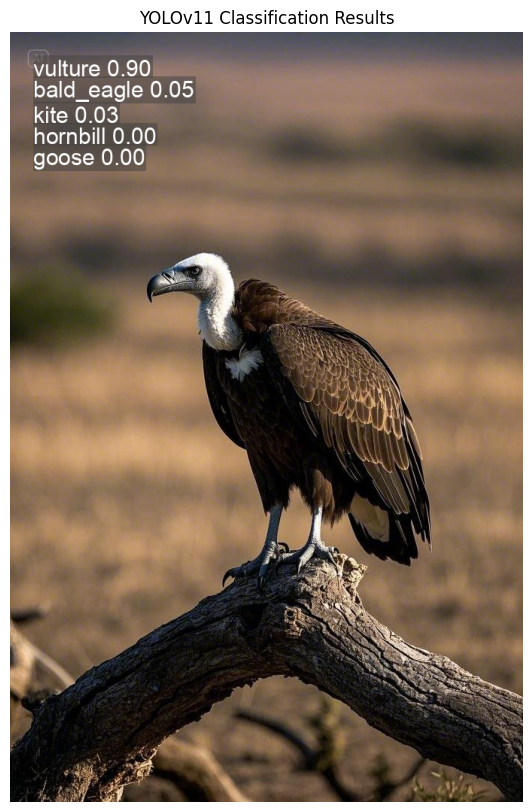

In [14]:
cls = model.predict("sample-5.jpg")
plt.figure(figsize=(10, 10))  # set figure size
plt.title("YOLOv11 Classification Results")  # set title
plt.axis('off')  # hide axes
plt.imshow(cv2.cvtColor(cls[0].plot(), cv2.COLOR_BGR2RGB))  # plot results

--2025-05-09 06:03:23--  https://i.pinimg.com/736x/40/91/2d/40912da5a423ac2fefd53eec58007a05.jpg
Resolving i.pinimg.com (i.pinimg.com)... 151.101.192.84, 151.101.128.84, 151.101.64.84, ...
Connecting to i.pinimg.com (i.pinimg.com)|151.101.192.84|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88711 (87K) [image/jpeg]
Saving to: ‘sample-6.jpg’

sample-6.jpg        100%[===================>]  86.63K  --.-KB/s    in 0.02s   

2025-05-09 06:03:23 (5.53 MB/s) - ‘sample-6.jpg’ saved [88711/88711]


image 1/1 /home/HP/Jupyter_Notebooks/YOLO-EXP/sample-6.jpg: 224x224 bald_eagle 1.00, kite 0.00, vulture 0.00, hornbill 0.00, albatross 0.00, 6.3ms
Speed: 12.2ms preprocess, 6.3ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)


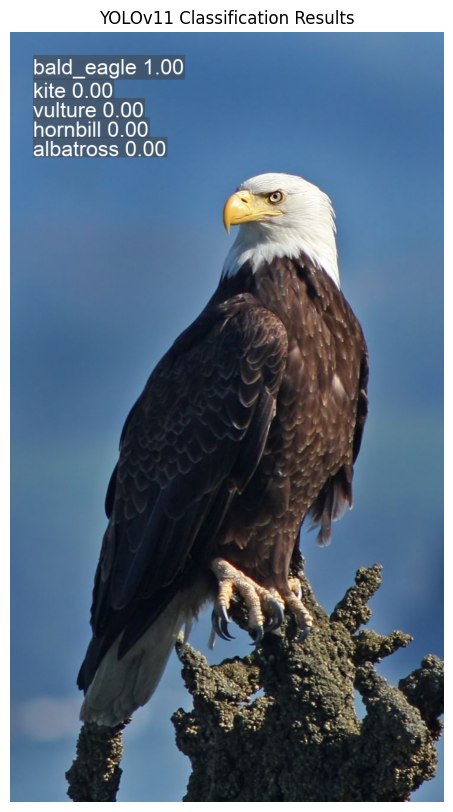

In [15]:
!wget -O sample-6.jpg https://i.pinimg.com/736x/40/91/2d/40912da5a423ac2fefd53eec58007a05.jpg
cls = model.predict("sample-6.jpg")
plt.figure(figsize=(10, 10))  # set figure size
plt.title("YOLOv11 Classification Results")  # set title
plt.axis('off')  # hide axes
plt.imshow(cv2.cvtColor(cls[0].plot(), cv2.COLOR_BGR2RGB))  # plot results

In [16]:
# cls[0].names # get class names

# Object Detection

In [17]:
model = YOLO("yolo11n.pt")

In [ ]:
obj = model.predict("sample-2.jpg")
plt.figure(figsize=(10, 10))  # set figure size
plt.title("YOLOv11 Object Detection Results")  # set title
plt.axis('off')  # hide axes
plt.imshow(cv2.cvtColor(obj[0].plot(), cv2.COLOR_BGR2RGB))  # plot results


image 1/1 /home/HP/Jupyter_Notebooks/YOLO-EXP/sample-2.jpg: 384x640 2 persons, 2 horses, 12.1ms
Speed: 1.6ms preprocess, 12.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)
